<h1 style="text-align: center;">Mini-project n° 4 – RNN, LSTM and GRU vs MLP and CNN</h1>


### Group 5 : 

Vilde OPDAL

Laura VAZQUEZ-ARELLANO

Minh-Thi BUI

Thanh-Chung NGUYEN



# **Introduction**

This project focuses on sentiment classification using the IMDB dataset, a benchmark dataset containing labeled movie reviews for binary sentiment analysis. To achieve this, various deep learning architectures, including RNNs, LSTMs, GRUs, MLPs, and CNNs, are employed to explore their effectiveness in handling textual data. 

Objectives:

* Model Comparison: Evaluate and compare the performance of RNNs, LSTMs, GRUs, MLPs, and CNNs in terms of accuracy, memory usage, and computational time on the IMDB dataset.

* Ensemble Learning: Implement an ensemble method based on majority voting to assess whether combining predictions from different architectures improves the overall results.

* Pretraining with Unlabeled Data: Leverage the additional unlabeled IMDB data for pretraining the models and investigate its impact on fine-tuned performance in sentiment classification.

* Insights: Analyze trade-offs between model complexity, performance, and efficiency to provide recommendations for real-world sentiment analysis tasks

### Import the necessary libraries

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import string
import os
import warnings
warnings.filterwarnings('ignore')

# Natural Language Processing
from textblob import Word, TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
nltk.data.path.append("/kaggle/working/")
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Download necessary NLTK resources
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Load SpaCy model
import spacy
nlp = spacy.load("en_core_web_sm")
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", font_scale=1.5)
sns.set(rc={"axes.facecolor": "#FFFAF0", "figure.facecolor": "#FFFAF0"})
sns.set_context("poster", font_scale=0.7)


# Text Preprocessing
import contractions
import re, string, unicodedata
from wordcloud import WordCloud, STOPWORDS

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import lil_matrix
from joblib import Parallel, delayed
import math

# Deep Learning
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SimpleRNN, LSTM, GRU, Embedding, Dense,
    SpatialDropout1D, Dropout, BatchNormalization,
    Bidirectional
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/corp_sysops/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corp_sysops/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/corp_sysops/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corp_sysops/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To make it easier to process and use the dataset, we organize them into Data Frames.

In [ ]:
def verify_path_exists(path):
    """Check if the specified path exists."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"The path {path} does not exist. Please check the folder location.")
    print(f"Path verified: {path}")

def combine_txt_to_csv(base_folder, output_csv):
    """
    Combine .txt files from 'pos' and 'neg' folders in the base folder into a CSV file.
    :param base_folder: Path to the main folder containing 'pos' and 'neg' subfolders.
    :param output_csv: Path to save the combined CSV file.
    """
    # Verify if the base folder exists
    verify_path_exists(base_folder)

    # Initialize lists to store the text content and labels
    data = []
    labels = []

    # Iterate over 'pos' and 'neg' folders
    for label in ['pos', 'neg']:
        folder_path = os.path.join(base_folder, label)
        if os.path.exists(folder_path):  # Check if subfolder exists
            print(f"Processing folder: {folder_path}")
            for filename in os.listdir(folder_path):
                if filename.endswith(".txt"):
                    file_path = os.path.join(folder_path, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
                            content = file.read().strip()  # Remove leading/trailing spaces
                            if content:  # Avoid empty files
                                data.append(content)  # Append the entire content as a single string
                                labels.append(label)
                            else:
                                print(f"Skipped empty file: {file_path}")
                    except Exception as e:
                        print(f"Error reading file {file_path}: {e}")
        else:
            print(f"Folder not found: {folder_path}")

    # Check if data was collected
    if not data:
        raise ValueError("No data found in the specified folders. Please check the folder structure.")

    # Create a DataFrame
    train = pd.DataFrame({'text': data, 'label': labels})

    # Save to a CSV file with proper quoting
    train.to_csv(output_csv, index=False, encoding='utf-8', quoting=1)  # quoting=1 adds quotes around text
    print(f"Combined CSV saved to {output_csv}")

# Paths for train and test folders and their corresponding output CSV files
base_folder_train = "aclImdb/train/"
output_csv_train = "combined_train.csv"

try:
    combine_txt_to_csv(base_folder_train, output_csv_train)
except Exception as e:
    print(f"Error processing training data: {e}")

base_folder_test = "aclImdb/test/"
output_csv_test = "combined_test.csv"

try:
    combine_txt_to_csv(base_folder_test, output_csv_test)
except Exception as e:
    print(f"Error processing test data: {e}")


# Dataset

In [573]:
train = pd.read_csv("combined_train.csv")
test = pd.read_csv("combined_test.csv")

In [575]:
print(train.head())
print(train.shape)
print(train.info())
print("Duplicates in Dataset: ",train.duplicated().sum())

                                                text label
0  Zentropa has much in common with The Third Man...   pos
1  Zentropa is the most original movie I've seen ...   pos
2  Lars Von Trier is never backward in trying out...   pos
3  *Contains spoilers due to me having to describ...   pos
4  That was the first thing that sprang to mind a...   pos
(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB
None
Duplicates in Dataset:  96


In [577]:
train.drop_duplicates(inplace = True)
print("Duplicates in Dataset after dropping: ",train.duplicated().sum())

Duplicates in Dataset after dropping:  0


In [579]:
missing_data = train.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
text,0,0.0
label,0,0.0


In [581]:
round(train.describe(include="O").T,2)

,count,unique,top,freq
text,24904,24904,Zentropa has much in common with The Third Man...,1
label,24904,2,pos,12472


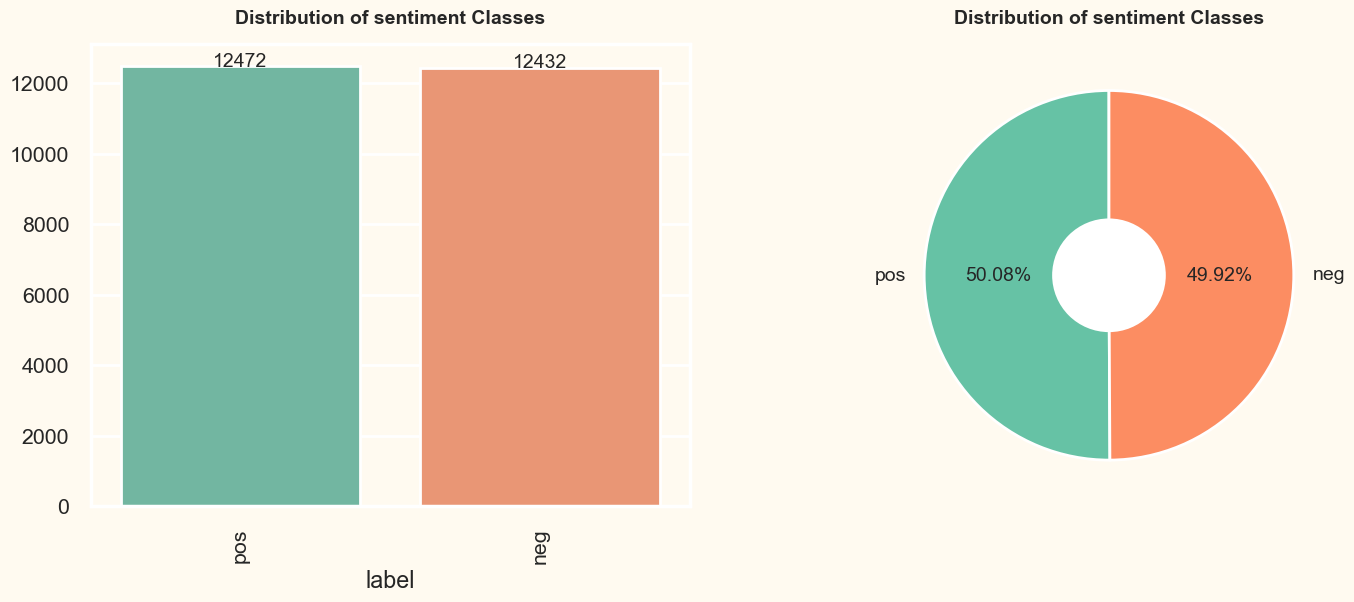

In [583]:
classes = ['pos','neg']

plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
sentiment_counts = train["label"].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2', order=classes)
plt.title("Distribution of sentiment Classes", fontweight="black", size=14, pad=15)
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, v, ha="center", fontsize=14)
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
colors = sns.color_palette('Set2', len(classes))
plt.pie(sentiment_counts, labels=classes, autopct="%.2f%%", textprops={"size": 14},
        colors=colors, startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of sentiment Classes", fontweight="black", size=14, pad=15)
plt.show()

## Data preprocessing

Preprocessing is essential to clean and standardize the IMDB dataset by removing noise such as special characters, URLs, and stopwords, ensuring the model focuses on meaningful content. These steps enhance the model's ability to learn patterns effectively, improving sentiment analysis accuracy and efficiency.

- **Lowercasing:** Ensures uniformity by treating "The" and "the" as the same word.  
- **Removing HTML tags, special characters, URLs, and emojis:** Eliminates irrelevant noise that may confuse the model.  
- **Expanding contractions and abbreviations:** Restores semantic clarity, e.g., "don't" to "do not" and "LOL" to "laughing out loud."  
- **Removing stopwords:** Focuses on meaningful words by excluding common words like "is" or "the."  
- **Lemmatization:** Reduces words to their base form, e.g., "running" to "run," minimizing redundancy.  
**=> Overall:** These steps ensure the model learns patterns and sentiments more effectively, improving accuracy.  

In [23]:
# Define preprocessing functions
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    
    # Remove HTML tags and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    
    # Remove emojis
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"      # symbols & pictographs
        u"\U0001F680-\U0001F6FF"      # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"      # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Replace chat abbreviations
    text = " ".join(chat_words.get(word.upper(), word) for word in text.split())
    
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join(token.lemma_ for token in doc)

# Chat abbreviations dictionary
chat_words = {
    "LOL": "Laughing Out Loud", "BRB": "Be Right Back", "ASAP": "As Soon As Possible",
    "BTW": "By The Way", "IRL": "In Real Life", "THX": "Thank You", "IDC": "I Don’t Care",
    "ILY": "I Love You", "TTYL": "Talk To You Later", "WYWH": "Wish You Were Here",
}


In [ ]:
# Apply preprocessing and lemmatization to training and testing data
train['text'] = train['text'].apply(preprocess_text).apply(lemmatize_text)
test['text'] = test['text'].apply(preprocess_text).apply(lemmatize_text)

In [587]:
train = pd.read_csv('processed_train.csv') 
test = pd.read_csv('processed_test.csv') 


### Tokenization

Tokenization splits text into individual words or tokens, converting raw text into a structured format suitable for model input. 

It is essential because models require numerical or tokenized representations of text to learn patterns and relationships effectively.

In [589]:
def do_tokenization(text):
    
    token_words = word_tokenize(text)
    return token_words

train['text'] = train['text'].apply(do_tokenization)
test['text'] = test['text'].apply(do_tokenization)

In [596]:
X_train,X_test,y_train,y_test = train["text"], test["text"], train["label"], test["label"] 

In [600]:
X_train.head()

0    [zentropa, much, common, third, man, another, ...
1    [zentropa, original, movie, see, year, like, u...
2    [lars, von, trier, never, backward, try, new, ...
3    [contain, spoiler, due, describe, film, techni...
4    [first, thing, sprang, mind, watch, closing, c...
Name: text, dtype: object

### Text-to-Sequence Conversion







This code converts text into numerical sequences using a tokenizer, mapping each word to a unique integer. 

It is necessary because machine learning models work with numerical data, and this step ensures consistent and efficient representation of text for training and evaluation.

In [385]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

print(len(tokenizer.word_index))

tokenizer.document_count

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

for num in X_train[0]:
    print(num, end=' ')

107722
10872 24 955 683 42 74 35756 3 97 635 12511 5577 1959 7 47813 24 3665 275 49 1104 217 9 1812 276 73 19 218 495 12072 953 1465 35757 1 346 320 26 683 42 9027 605 10872 117 3885 851 283 5722 389 47814 6 3499 12 1238 151 1 1 2 19752 47815 4 180 4 51 5 2360 1217 2186 1813 2195 

In [387]:
# Print corresponding words horizontally
for num in X_train[0]:
    word = tokenizer.index_word.get(num, 'UNK')  
    print(word, end=' ')


zentropa much common third man another noirlike film set among rubble postwar europe like ttm much inventive camera work innocent american get emotionally involve woman really understand whose naivety strike contrast nativesbr br i d say third man wellcrafte storyline zentropa bit disjoint respect perhaps intentional present dreamnightmare make coherent would spoil effect br br movie unrelentingly grimnoir one sense one never see sun shine grim intriguing frightening 

In [389]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

### Padding the data 

This code determines the maximum sequence length in `X_train` and ensures all sequences in `X_train` and `X_test` are padded to a fixed length (`maxlen=100`). 

Padding standardizes sequence lengths, making the data suitable for batch processing in models while preserving temporal relationships. It ensures shorter sequences do not cause inconsistencies during training.

In [391]:
max_length = 0
for sequence in X_train:
    # Calculate the length of the sequence
    sequence_length = len(sequence)
    # Update max_length if the current sequence length is greater
    if sequence_length > max_length:
        max_length = sequence_length

print("Maximum sequence length:", max_length)

X_train=pad_sequences(X_train,maxlen=100,padding="post")
X_test=pad_sequences(X_test,maxlen=100,padding="post")

X_train[0]


Maximum sequence length: 1441


array([10872,    24,   955,   683,    42,    74, 35756,     3,    97,
         635, 12511,  5577,  1959,     7, 47813,    24,  3665,   275,
          49,  1104,   217,     9,  1812,   276,    73,    19,   218,
         495, 12072,   953,  1465, 35757,     1,   346,   320,    26,
         683,    42,  9027,   605, 10872,   117,  3885,   851,   283,
        5722,   389, 47814,     6,  3499,    12,  1238,   151,     1,
           1,     2, 19752, 47815,     4,   180,     4,    51,     5,
        2360,  1217,  2186,  1813,  2195,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

# Building and Optimizing Models


This section focuses on constructing and fine-tuning deep learning models for sentiment analysis. Various architectures, such as RNNs, LSTMs, GRUs, CNNs, and MLPs, are implemented and optimized through hyperparameter tuning to achieve the best performance in terms of accuracy, computational efficiency, and memory usage.

In [398]:
from tensorflow.keras.callbacks import Callback
import time  

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start_time)

number_epochs = 10
max_trials    = 10

In this part, `RandomSearch` is used for hyperparameter optimization across all five models (RNN, LSTM, GRU, MLP, CNN). Its purpose is to automate and efficiently explore the hyperparameter space to find the best configuration for each model. Here are reason why we use RandomSearch:

- **Efficient Exploration**: RandomSearch randomly samples hyperparameter combinations within specified ranges, which is faster and computationally less expensive -compared to exhaustive search methods like GridSearch.

- **High Performance with Limited Trials**: It has been shown to perform well even with a limited number of trials, often discovering near-optimal configurations by exploring diverse regions of the hyperparameter space.

- **Scalability**: It can handle large hyperparameter spaces without requiring the evaluation of every possible combination, making it suitable for complex models like LSTMs and CNNs.

## RNN

In [400]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential

# Define the Hyper RNN Model for Tuning
def Hyper_RNN_model(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Number of RNN layers
    num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=3)  # Define hyperparameter once
    for i in range(num_rnn_layers):
        model.add(SimpleRNN(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),  # Units in each layer
            return_sequences=(i != num_rnn_layers - 1),  # False for the last layer
            activation='tanh'))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())

    # Dense Layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3)  # Define hyperparameter once
    for i in range(num_dense_layers):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)))
        model.add(Dropout(rate=hp.Float(f'dropout_dense_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_RNN_model,
    objective='val_accuracy',
    max_trials=1,  # Number of hyperparameter combinations to try
    directory='hyper_rnn_tuning',
    project_name='Hyper_RNN'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_RNN = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_RNN = TimeHistory()


# Evaluate Best Model
history_best_RNN = best_model_RNN.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_RNN]
)

# Get epoch times
print(f"RNN Time Per Epoch: {time_callback_RNN.epoch_times}")
print(f"RNN Total Training Time: {sum(time_callback_RNN.epoch_times):.2f} seconds")
print(f"RNN Average Time Per Epoch: {(sum(time_callback_RNN.epoch_times))/number_epochs:.2f} seconds")


Trial 10 Complete [00h 09m 35s]
val_accuracy: 0.5081200003623962

Best val_accuracy So Far: 0.8440399765968323
Total elapsed time: 05h 43m 39s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.9362 - loss: 0.2766 - val_accuracy: 0.8358 - val_loss: 0.5724
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9605 - loss: 0.1954 - val_accuracy: 0.8337 - val_loss: 0.4766
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9723 - loss: 0.1395 - val_accuracy: 0.8358 - val_loss: 0.5613
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9815 - loss: 0.1018 - val_accuracy: 0.8246 - val_loss: 0.7105
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9850 - loss: 0.0784 - val_accuracy: 0.7984 - val_loss: 1.0934
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9817 - loss: 0.0822 - val_accuracy: 0.8184 - val_loss: 0.7900
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.9886 - lo

**Explanation of Choices for RNN Model**
1. Choice of Architecture
- Embedding Layer: Converts input text sequences into dense vector representations, allowing the model to understand semantic relationships between words.
Parameters: input_dim (vocabulary size), output_dim (embedding vector size, chosen as 100 for a balance of computational cost and information richness), and input_length (fixed sequence length).

- RNN Layers:

Type: SimpleRNN is chosen for its straightforward implementation to process sequential data by retaining temporal dependencies.

Layer Count: Tuned (num_rnn_layers) between 1 and 3 to explore optimal depth for learning sequential patterns.

Layer Size: Tuned (units) between 32 and 128 to balance capacity and computational efficiency.

Activation: "tanh" is used to capture both positive and negative dependencies in sequential data.

- Dense Layers:

Fully connected layers are added after the RNN layers for further representation learning and classification.

Layer Count: Tuned (num_dense_layers) between 1 and 3 to find the right trade-off between simplicity and model expressiveness.

Layer Size: Tuned (dense_units) between 32 and 128 to optimize for capacity and performance.

Activation: "relu" is chosen for its non-linear properties and ability to mitigate vanishing gradient issues.

Output Layer: A single Dense layer with a "sigmoid" activation is used for binary classification (positive/negative sentiment).

2. Choice of Hyperparameters

- Batch Size: Fixed at 32 to maintain a balance between memory efficiency and training speed. A smaller batch size allows the model to learn more fine-grained updates, but larger sizes might reduce noise.

- Learning Rate: Tuned between 1e-2, 1e-3, and 1e-4 to optimize the speed of convergence without overshooting the loss minima.

- Dropout Rates: Tuned for both RNN and Dense layers (dropout_rate) between 0.1 and 0.5 to prevent overfitting by randomly disabling neurons during training.
Regularization:

- L2 regularization is applied to Dense layers (kernel_regularizer=l2(0.01)) to discourage large weights and improve generalization.

3. Choice of Loss Function
   
Loss Function: binary_crossentropy

RNNs are designed to process sequential data and output probabilities for binary classification. 

The binary_crossentropy loss ensures that the model optimizes its predictions towards the correct binary class with minimal error.

It works seamlessly with the sigmoid activation function in the output layer, as the combination ensures the output probabilities fall between 0 and 1.

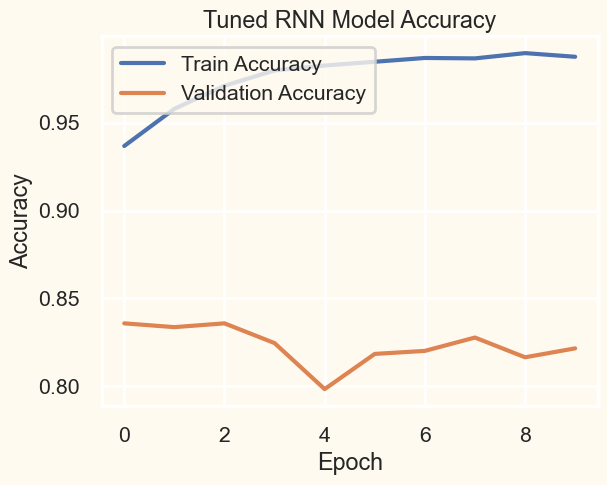

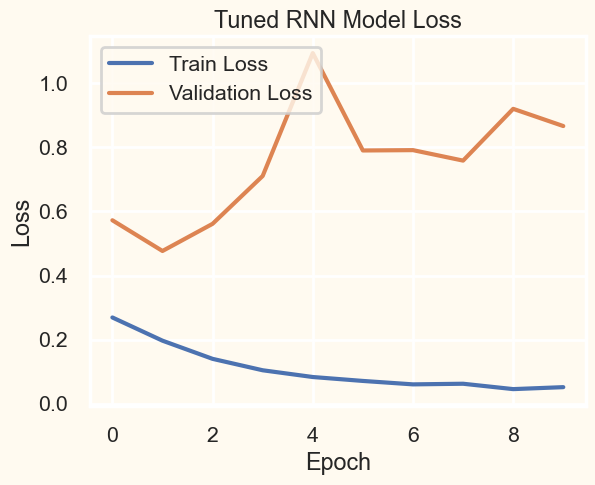

In [628]:
# Plot training and validation accuracy
plt.plot(history_best_RNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_RNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

print("")

# Plot training and validation loss
plt.plot(history_best_RNN.history['loss'], label='Train Loss')
plt.plot(history_best_RNN.history['val_loss'], label='Validation Loss')
plt.title('Tuned RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [509]:
best_model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,400,745 (123.60 MB)

 Trainable params: 10,800,077 (41.20 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 21,600,156 (82.40 MB)

In [402]:
# Display the summary of the tuning results
tuner.results_summary()

Results summary
Results in hyper_rnn_tuning/Hyper_RNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
num_rnn_layers: 2
units_0: 64
dropout_rate_0: 0.4
num_dense_layers: 1
dense_units_0: 128
dropout_dense_0: 0.2
learning_rate: 0.0001
units_1: 64
dropout_rate_1: 0.4
units_2: 96
dropout_rate_2: 0.5
dense_units_1: 64
dropout_dense_1: 0.2
dense_units_2: 96
dropout_dense_2: 0.5
Score: 0.8440399765968323

Trial 08 summary
Hyperparameters:
num_rnn_layers: 1
units_0: 96
dropout_rate_0: 0.1
num_dense_layers: 1
dense_units_0: 96
dropout_dense_0: 0.5
learning_rate: 0.0001
units_1: 96
dropout_rate_1: 0.5
units_2: 128
dropout_rate_2: 0.2
dense_units_1: 64
dropout_dense_1: 0.4
dense_units_2: 128
dropout_dense_2: 0.1
Score: 0.8422799706459045

Trial 04 summary
Hyperparameters:
num_rnn_layers: 1
units_0: 96
dropout_rate_0: 0.30000000000000004
num_dense_layers: 1
dense_units_0: 128
dropout_dense_0: 0.4
learning_rate: 0.0001
units_1: 32
dropout_r

##  Bidirectional RNN

In [403]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Embedding, Dense, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Define the Hyperparameter-tuned Bidirectional RNN model
def Hyper_Bidirectional_RNN_model(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Spatial Dropout
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add Bidirectional RNN Layers
    num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=3)  # Define once
    for i in range(num_rnn_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        model.add(Bidirectional(SimpleRNN(
            units,
            return_sequences=(i != num_rnn_layers - 1)  # Use the predefined `num_rnn_layers`
        )))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Fully Connected Layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3)  # Define once
    for i in range(num_dense_layers):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_Bidirectional_RNN_model,
    objective='val_accuracy',
    max_trials=max_trials,  # Number of hyperparameter combinations to try
    directory='hyper_bi_rnn_tuning',
    project_name='Hyper_Bidirectional_RNN'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_BiRNN = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_BiRNN = TimeHistory()

# Evaluate Best Model
history_best_BiRNN = best_model_BiRNN.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_BiRNN]
)


# Get epoch times
print(f"BiRNN Time Per Epoch: {time_callback_BiRNN.epoch_times}")
print(f"BiRNN Total Training Time: {sum(time_callback_BiRNN.epoch_times):.2f} seconds")
print(f"BiRNN Average Time Per Epoch: {(sum(time_callback_BiRNN.epoch_times))/number_epochs:.2f} seconds")


Trial 10 Complete [00h 07m 54s]
val_accuracy: 0.5763999819755554

Best val_accuracy So Far: 0.8486800193786621
Total elapsed time: 06h 48m 26s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.9399 - loss: 0.3387 - val_accuracy: 0.8493 - val_loss: 0.5443
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.9548 - loss: 0.2512 - val_accuracy: 0.8504 - val_loss: 0.5607
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.9625 - loss: 0.1941 - val_accuracy: 0.8388 - val_loss: 0.5996
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.9739 - loss: 0.1447 - val_accuracy: 0.8459 - val_loss: 0.6161
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.9802 - loss: 0.1136 - val_accuracy: 0.8435 - val_loss: 0.5858
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.9787 - loss: 0.1003 - val_accuracy: 0.8428 - val_loss: 0.6839
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.9844 - lo

**Explanation of Choices for Bidirectional RNN Model** 

1. Choice of Architecture
- Embedding Layer: Same with RNN

- Spatial Dropout Layer: SpatialDropout1D is applied to the embedding layer to randomly drop entire embedding dimensions, to prevents overfitting and encourages the model to rely on a broader range of features.

- Bidirectional RNN Layers:

Type: Bidirectional(SimpleRNN) processes sequences in both forward and backward directions, capturing context from both ends.

Layer Count and Layer Size: Same with RNN, use RandomSearch to find the best.

Return Sequences: Set to True for all but the last RNN layer, ensuring the correct flow of temporal features

Dropout and Batch Normalization: Each layer is followed by dropout and batch normalization to reduce overfitting and stabilize training.

- Dense Layers:

Fully connected layers are added after the RNN layers to process high-level features.

Regularization: L2 regularization is applied to reduce overfitting.

Activation: relu is used for its effectiveness in learning non-linear patterns.

Output Layer: A single Dense layer with a sigmoid activation is used for binary classification (positive/negative sentiment).

2. Choice of Hyperparameters
   
Batch Size, Learning Rate, Dropout Rates: Same with RNN, use RandomSearch to find the best.

L2 regularization in Dense layers discourages large weights, improving generalization.

3. Choice of Loss Function
   
Loss Function: binary_crossentropy

In Bidirectional RNNs, the model captures context from both past and future sequences. 

Using binary_crossentropy helps evaluate the combined forward and backward predictions effectively for binary classification.

This ensures that the enriched contextual information from BiRNN is utilized to minimize classification errors.


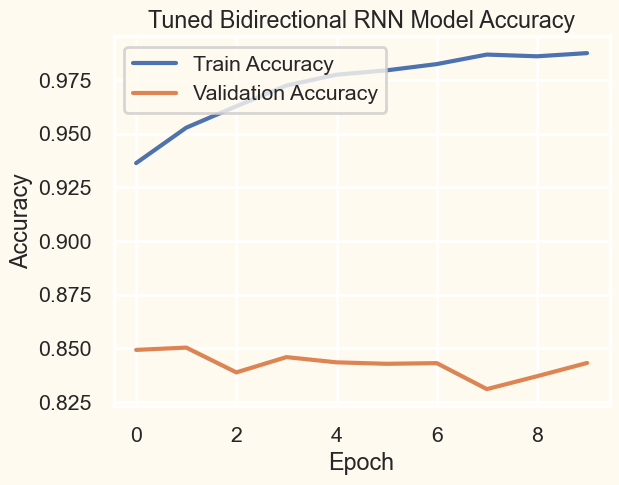

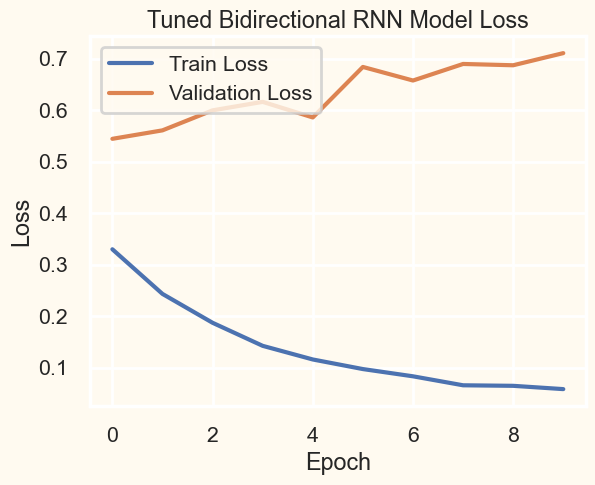

In [404]:
# Plot training and validation accuracy
plt.plot(history_best_BiRNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_BiRNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Bidirectional RNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history_best_BiRNN.history['loss'], label='Train Loss')
plt.plot(history_best_BiRNN.history['val_loss'], label='Validation Loss')
plt.title('Tuned Bidirectional RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [643]:
best_model_BiRNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 64)        │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 192)            │        30,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,463,049 (123.84 MB)

 Trainable params: 10,820,781 (41.28 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 21,641,564 (82.56 MB)

In [645]:
# Display the tuning results
tuner.results_summary()


Results summary
Results in hyper_cnn_tuning/Hyper_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 96
dropout_rate_0: 0.4
learning_rate: 0.001
dense_units_1: 96
dropout_rate_1: 0.4
filters_1: 96
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 64
dropout_rate_2: 0.2
filters_2: 32
kernel_size_2: 3
pool_size_2: 2
Score: 0.8402400016784668

Trial 03 summary
Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
pool_size_0: 2
num_dense_layers: 1
dense_units_0: 96
dropout_rate_0: 0.1
learning_rate: 0.001
dense_units_1: 32
dropout_rate_1: 0.30000000000000004
filters_1: 64
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 128
dropout_rate_2: 0.1
Score: 0.8399999737739563

Trial 01 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 64
dropout_rate_0: 0.5

## LSTM

In [406]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Define the Hyperparameter-tuned LSTM model
def Hyper_LSTM_model(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Spatial Dropout
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Number of LSTM layers
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3)  # Define once
    for i in range(num_lstm_layers):
        units = hp.Int(f'lstm_units_{i}', min_value=16, max_value=128, step=16)
        model.add(LSTM(
            units,
            return_sequences=(i != num_lstm_layers - 1),  # False for the last LSTM layer
            activation='tanh'
        ))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Number of Dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2)  # Define once
    for i in range(num_dense_layers):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_LSTM_model,
    objective='val_accuracy',
    max_trials=max_trials,  # Number of hyperparameter combinations to try
    directory='hyper_lstm_tuning',
    project_name='Hyper_LSTM'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_LSTM = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_LSTM = TimeHistory()

# Evaluate Best Model
history_best_LSTM = best_model_LSTM.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_LSTM]
)

# Get epoch times
print(f"LSTM Time Per Epoch: {time_callback_LSTM.epoch_times}")
print(f"LSTM Total Training Time: {sum(time_callback_LSTM.epoch_times):.2f} seconds")
print(f"LSTM Average Time Per Epoch: {(sum(time_callback_LSTM.epoch_times))/number_epochs:.2f} seconds")



Trial 10 Complete [00h 17m 56s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.8525999784469604
Total elapsed time: 08h 16m 29s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.9320 - loss: 0.2144 - val_accuracy: 0.8481 - val_loss: 0.4413
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9548 - loss: 0.1449 - val_accuracy: 0.8398 - val_loss: 0.5637
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9693 - loss: 0.1085 - val_accuracy: 0.8238 - val_loss: 0.6920
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9739 - loss: 0.0931 - val_accuracy: 0.8465 - val_loss: 0.6212
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9811 - loss: 0.0715 - val_accuracy: 0.8394 - val_loss: 0.6724
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9818 - loss: 0.0698 - val_accuracy: 0.8387 - val_loss: 0.6727
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9859 - loss: 0.0620 - va

**Explanation of Choices for LSTM Model**

1. Choice of Architecture

Embedding Layer: Same with previous models.

- LSTM Layers:

Type: LSTM (Long Short-Term Memory) layers are chosen for their ability to retain long-term dependencies in sequential data.

Return Sequences: Enabled for all but the last LSTM layer to ensure proper feature flow.

Activation: tanh is used to handle sequential dependencies effectively.

Dropout and Batch Normalization: Applied after each layer to reduce overfitting and stabilize training.

- Dense Layers:

Added after LSTM layers for feature extraction and final classification.

Regularization: L2 regularization applied to reduce overfitting.

Activation: relu for learning complex non-linear patterns.

Output Layer: A single Dense layer with a sigmoid activation for binary classification (positive/negative sentiment).

2. Choice of Hyperparameters

L2 regularization in Dense layers helps control large weights and improve generalization.

3. Choice of Loss Function
Loss Function: binary_crossentropy

To measure the difference between predicted probabilities and true labels.

It works effectively with sigmoid activation, penalizing incorrect predictions based on their confidence.

Suitable for binary classification problems where the output is probabilistic (0 or 1).

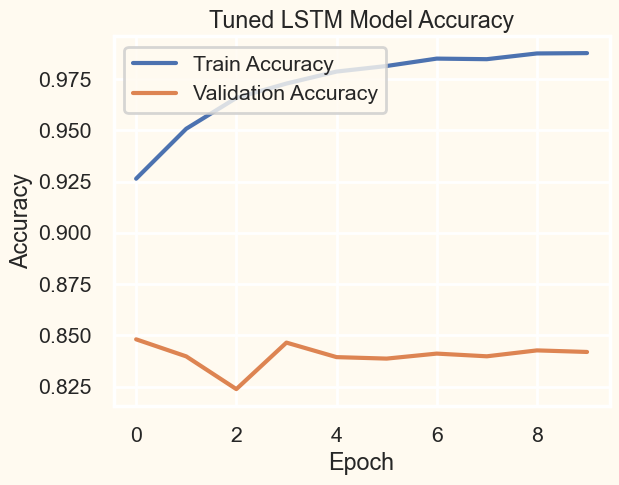

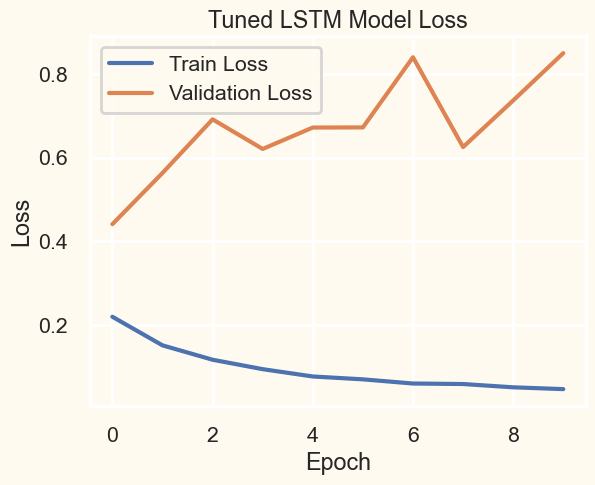

In [407]:
# Plot training and validation accuracy
plt.plot(history_best_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history_best_LSTM.history['loss'], label='Train Loss')
plt.plot(history_best_LSTM.history['val_loss'], label='Validation Loss')
plt.title('Tuned LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [653]:
best_model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 16)        │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 32)        │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,372,073 (123.49 MB)

 Trainable params: 10,790,605 (41.16 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 21,581,212 (82.33 MB)

In [655]:
# Display the tuning results
tuner.results_summary()



Results summary
Results in hyper_cnn_tuning/Hyper_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 96
dropout_rate_0: 0.4
learning_rate: 0.001
dense_units_1: 96
dropout_rate_1: 0.4
filters_1: 96
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 64
dropout_rate_2: 0.2
filters_2: 32
kernel_size_2: 3
pool_size_2: 2
Score: 0.8402400016784668

Trial 03 summary
Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
pool_size_0: 2
num_dense_layers: 1
dense_units_0: 96
dropout_rate_0: 0.1
learning_rate: 0.001
dense_units_1: 32
dropout_rate_1: 0.30000000000000004
filters_1: 64
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 128
dropout_rate_2: 0.1
Score: 0.8399999737739563

Trial 01 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 64
dropout_rate_0: 0.5

In [89]:
# Define the model
GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=100))
GRU_model.add(SpatialDropout1D(0.5))
GRU_model.add(GRU(5, return_sequences=False))
GRU_model.add(Dropout(0.5))
#GRU_model.add(BatchNormalization())


GRU_model.add(Dense(1, activation='sigmoid'))

# Summarize the model
GRU_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = GRU_model.fit(X_train, y_train, epochs=1, batch_size=256, validation_data=(X_test, y_test))

98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5254 - loss: 0.6914 - val_accuracy: 0.5655 - val_loss: 0.6789


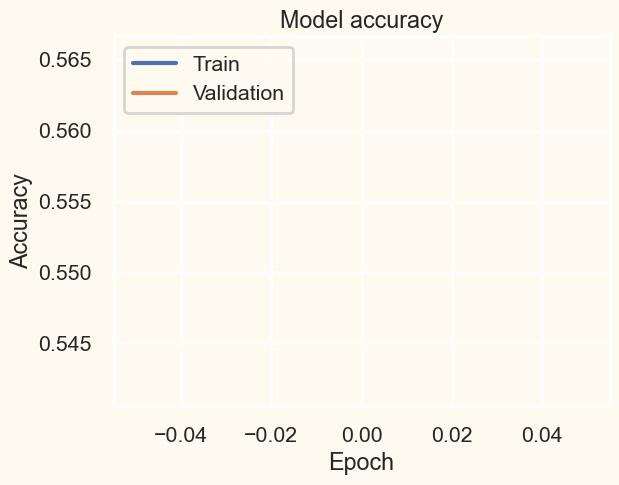

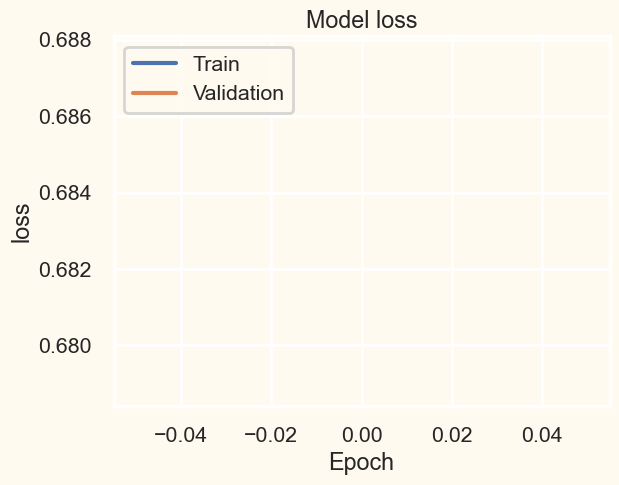

In [91]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## GRU 

In [409]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import GRU, Embedding, Dense, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Define the Hyperparameter-tuned GRU model
def Hyper_GRU_model(hp):
    model = Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Spatial Dropout
    model.add(SpatialDropout1D(hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Number of GRU layers
    num_gru_layers = hp.Int('num_gru_layers', min_value=1, max_value=3)  # Define once
    for i in range(num_gru_layers):
        units = hp.Int(f'gru_units_{i}', min_value=16, max_value=128, step=16)
        model.add(GRU(
            units,
            return_sequences=(i != num_gru_layers - 1),  # False for the last GRU layer
            activation='tanh'
        ))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Number of Dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=2)  # Define once
    for i in range(num_dense_layers):
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_GRU_model,
    objective='val_accuracy',
    max_trials=max_trials,  # Number of hyperparameter combinations to try
    directory='hyper_gru_tuning',
    project_name='Hyper_GRU'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_GRU = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_GRU = TimeHistory()

# Evaluate Best Model
history_best_GRU = best_model_GRU.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_GRU]
)

# Get epoch times
print(f"GRU Time Per Epoch: {time_callback_GRU.epoch_times}")
print(f"GRU Total Training Time: {sum(time_callback_GRU.epoch_times):.2f} seconds")
print(f"GRU Average Time Per Epoch: {(sum(time_callback_GRU.epoch_times))/number_epochs:.2f} seconds")




Trial 10 Complete [00h 20m 17s]
val_accuracy: 0.853600025177002

Best val_accuracy So Far: 0.8638399839401245
Total elapsed time: 09h 44m 40s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9335 - loss: 0.2057 - val_accuracy: 0.8370 - val_loss: 0.4980
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9563 - loss: 0.1492 - val_accuracy: 0.8405 - val_loss: 0.4754
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9656 - loss: 0.1254 - val_accuracy: 0.8340 - val_loss: 0.4995
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9677 - loss: 0.1185 - val_accuracy: 0.7627 - val_loss: 0.6435
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9517 - loss: 0.1585 - val_accuracy: 0.8265 - val_loss: 0.5223
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9639 - loss: 0.1297 - val_accuracy: 0.8175 - val_loss: 0.6121
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.9439 - los

**Explanation of the GRU Model**

1. Choice of Architecture

- Spatial Dropout: A SpatialDropout1D layer is applied to the embedding output to randomly drop entire embedding dimensions during training, tor reduces overfitting by preventing the model from relying too heavily on specific dimensions of word embeddings.

- GRU Layers:

Type: GRU (Gated Recurrent Unit) is chosen as it efficiently handles sequential data with a simpler architecture compared to LSTM.

Return Sequences: Set to True for all but the last GRU layer to ensure proper feature flow across layers.

Activation: tanh is used for non-linear transformation within the GRU gates.

Dropout and Batch Normalization: Applied after each GRU layer to prevent overfitting and stabilize training.

- Dense Layers:

Fully connected layers for further feature extraction and binary classification.

Layer Count: Tuned (num_dense_layers) between 1 and 2 for optimal complexity.

Regularization: L2 regularization is applied to control large weights.

Activation: relu is used to introduce non-linearity.

- Output Layer: A single Dense layer with a sigmoid activation is used for binary classification (positive/negative sentiment).
  
2. Choice of Loss Function: binary_crossentropy
   
Computes the log loss for each binary prediction.

Measures the difference between the predicted probabilities and the actual binary labels (0 or 1).

GRU is particularly effective at learning sequential data. binary_crossentropy ensures the model minimizes prediction errors by penalizing incorrect probabilities more heavily as they deviate from the true label.

It works seamlessly with the sigmoid activation in the output layer, which outputs probabilities between 0 and 1.

3. Choice of Hyperparameters
4. 
L2 regularization in Dense layers controls large weights, improving generalization.

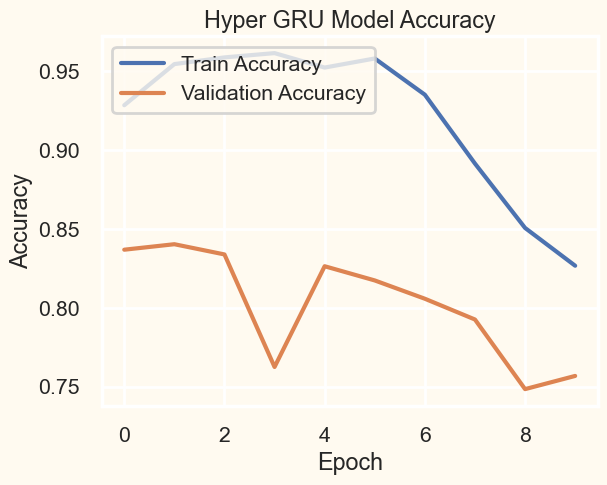

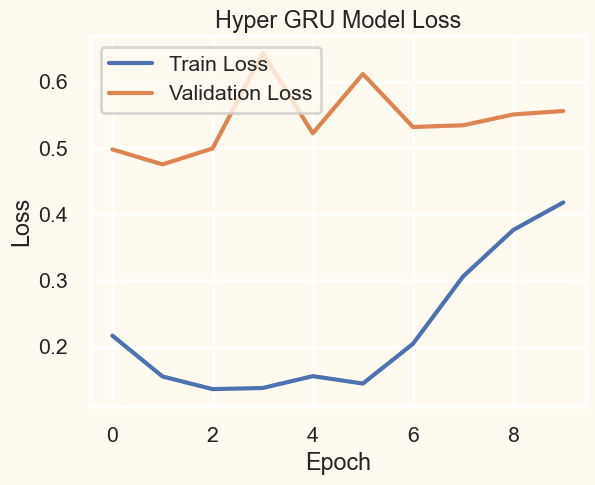

In [410]:
# Plot training and validation accuracy
plt.plot(history_best_GRU.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.title('Hyper GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history_best_GRU.history['loss'], label='Train Loss')
plt.plot(history_best_GRU.history['val_loss'], label='Validation Loss')
plt.title('Hyper GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [659]:
best_model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,359,273 (123.44 MB)

 Trainable params: 10,786,381 (41.15 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 21,572,764 (82.29 MB)

In [661]:
# Display the tuning results
tuner.results_summary()


Results summary
Results in hyper_cnn_tuning/Hyper_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 96
dropout_rate_0: 0.4
learning_rate: 0.001
dense_units_1: 96
dropout_rate_1: 0.4
filters_1: 96
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 64
dropout_rate_2: 0.2
filters_2: 32
kernel_size_2: 3
pool_size_2: 2
Score: 0.8402400016784668

Trial 03 summary
Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
pool_size_0: 2
num_dense_layers: 1
dense_units_0: 96
dropout_rate_0: 0.1
learning_rate: 0.001
dense_units_1: 32
dropout_rate_1: 0.30000000000000004
filters_1: 64
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 128
dropout_rate_2: 0.1
Score: 0.8399999737739563

Trial 01 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 64
dropout_rate_0: 0.5

## MLP

In [412]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the Hyperparameter-tuned MLP model
def Hyper_MLP_model(hp):
    model = keras.Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Flatten Layer
    model.add(Flatten())
    
    # Dense Layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):  # Between 1 and 3 layers
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_MLP_model,
    objective='val_accuracy',
    max_trials=max_trials,  # Number of hyperparameter combinations to try
    directory='hyper_mlp_tuning',
    project_name='Hyper_MLP'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_MLP = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_MLP = TimeHistory()


# Evaluate Best Model
history_best_MLP = best_model_MLP.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_MLP]
)

# Get epoch times
print(f"MLP Time Per Epoch: {time_callback_MLP.epoch_times}")
print(f"MLP Total Training Time: {sum(time_callback_MLP.epoch_times):.2f} seconds")
print(f"MLP Average Time Per Epoch: {(sum(time_callback_MLP.epoch_times))/number_epochs:.2f} seconds")




Trial 10 Complete [00h 03m 08s]
val_accuracy: 0.833840012550354

Best val_accuracy So Far: 0.833840012550354
Total elapsed time: 10h 07m 12s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9762 - loss: 0.2622 - val_accuracy: 0.8328 - val_loss: 0.5258
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9907 - loss: 0.1578 - val_accuracy: 0.8291 - val_loss: 0.5300
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9956 - loss: 0.1006 - val_accuracy: 0.8293 - val_loss: 0.5232
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9974 - loss: 0.0704 - val_accuracy: 0.8306 - val_loss: 0.5314
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9970 - loss: 0.0591 - val_accuracy: 0.8308 - val_loss: 0.5570
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9962 - loss: 0.0576 - val_accuracy: 0.8298 - val_loss: 0.5821
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9982 - loss

**Explanation of the MLP Model**

1. Choice of Architecture

- Flatten Layer: Flattens the 2D embedding matrix into a 1D vector for input to Dense layers, to allows the transition from the embedding space to fully connected layers for classification.

- Dense Layers:

Fully connected layers for extracting features and learning the classification task.

Regularization: L2 regularization (l2(0.01)) added to control large weight magnitudes, improving generalization.

Activation: relu introduces non-linearity for effective learning.

Dropout: Prevents overfitting by randomly dropping connections during training.

Batch Normalization: Stabilizes and accelerates training by normalizing the activations between layers.

- Output Layer: A single Dense layer with sigmoid activation for binary classification. Outputs probabilities for each class (0 or 1).

2. Choice of Loss Function: binary_crossentropy
   
Measures the difference between predicted probabilities and true binary labels (0 or 1).

Computes log loss, penalizing incorrect predictions based on confidence.

MLP processes input data as fixed-length vectors. Using binary_crossentropy ensures the model minimizes prediction errors for binary classification.

The sigmoid activation in the output layer and binary_crossentropy work together to optimize probability outputs for correct classification.

3. Choice of Hyperparameters

L2 regularization (l2(0.01)) in Dense layers to avoid overfitting by penalizing large weights.


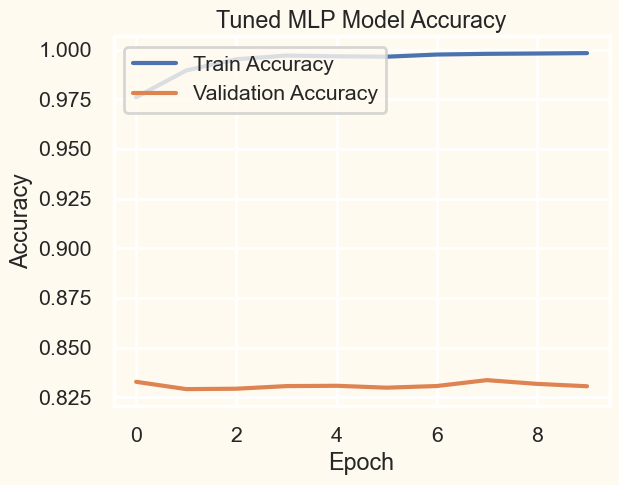

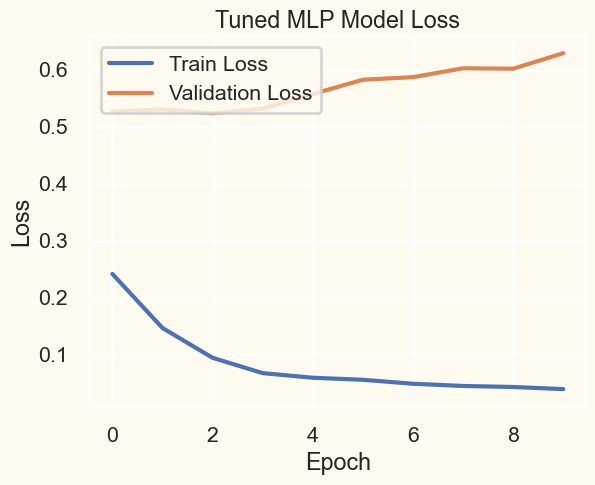

In [413]:
# Plot training and validation accuracy
plt.plot(history_best_MLP.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_MLP.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history_best_MLP.history['loss'], label='Train Loss')
plt.plot(history_best_MLP.history['val_loss'], label='Validation Loss')
plt.title('Tuned MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [664]:
best_model_MLP.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       320,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,277,353 (126.94 MB)

 Trainable params: 11,092,429 (42.31 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 22,184,860 (84.63 MB)

In [666]:
# Display the tuning results
tuner.results_summary()


Results summary
Results in hyper_cnn_tuning/Hyper_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 96
dropout_rate_0: 0.4
learning_rate: 0.001
dense_units_1: 96
dropout_rate_1: 0.4
filters_1: 96
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 64
dropout_rate_2: 0.2
filters_2: 32
kernel_size_2: 3
pool_size_2: 2
Score: 0.8402400016784668

Trial 03 summary
Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
pool_size_0: 2
num_dense_layers: 1
dense_units_0: 96
dropout_rate_0: 0.1
learning_rate: 0.001
dense_units_1: 32
dropout_rate_1: 0.30000000000000004
filters_1: 64
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 128
dropout_rate_2: 0.1
Score: 0.8399999737739563

Trial 01 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 64
dropout_rate_0: 0.5

## CNN

In [415]:
import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define the Hyperparameter-tuned CNN model
def Hyper_CNN_model(hp):
    model = keras.Sequential()
    
    # Embedding Layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                        output_dim=100, 
                        input_length=100))
    
    # Add Conv1D layers
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)):  # 1 to 3 Conv1D layers
        model.add(Conv1D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32), 
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5, 7]),
            activation='relu'
        ))
        model.add(MaxPooling1D(pool_size=hp.Choice(f'pool_size_{i}', values=[2, 3])))
        model.add(BatchNormalization())
    
    # Flatten Layer
    model.add(Flatten())
    
    # Fully Connected (Dense) Layers
    for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):  # 1 to 3 Dense layers
        model.add(Dense(
            units=hp.Int(f'dense_units_{i}', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the Keras Tuner
tuner = RandomSearch(
    Hyper_CNN_model,
    objective='val_accuracy',
    max_trials=max_trials,  # Number of hyperparameter combinations to try
    directory='hyper_cnn_tuning',
    project_name='Hyper_CNN'
)

# Perform Hyperparameter Search
tuner.search(
    X_train, y_train,
    epochs=number_epochs,  # Number of epochs for each trial
    validation_data=(X_test, y_test),
    batch_size=32  # Fixed batch size
)

# Get the Best Model
best_model_CNN = tuner.get_best_models(num_models=1)[0]

# Attach the callback
time_callback_CNN = TimeHistory()

# Evaluate Best Model
history_best_CNN = best_model_CNN.fit(
    X_train, y_train,
    epochs=number_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[time_callback_CNN]
)

# Get epoch times
print(f"CNN Time Per Epoch: {time_callback_CNN.epoch_times}")
print(f"CNN Total Training Time: {sum(time_callback_CNN.epoch_times):.2f} seconds")
print(f"CNN Average Time Per Epoch: {(sum(time_callback_CNN.epoch_times))/number_epochs:.2f} seconds")



Trial 10 Complete [00h 04m 04s]
val_accuracy: 0.8274000287055969

Best val_accuracy So Far: 0.8402400016784668
Total elapsed time: 10h 42m 14s
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.9383 - loss: 0.2320 - val_accuracy: 0.8295 - val_loss: 0.4690
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9426 - loss: 0.2044 - val_accuracy: 0.8208 - val_loss: 0.4875
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9565 - loss: 0.1685 - val_accuracy: 0.8335 - val_loss: 0.4996
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9664 - loss: 0.1447 - val_accuracy: 0.8371 - val_loss: 0.5030
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.9699 - loss: 0.1313 - val_accuracy: 0.8298 - val_loss: 0.5673
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9698 - loss: 0.1351 - val_accuracy: 0.8368 - val_loss: 0.5935
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9738 - lo

**Explanation of the CNN Model**

1. Choice of Architecture

Conv1D Layers: Extract spatial features by applying convolutional filters over the word embeddings.

  Tuned Parameters:
  
Number of convolutional layers (num_conv_layers): Tuned between 1 and 3.

Number of filters (filters): Tuned between 32 and 128 for feature extraction capacity.

Kernel size (kernel_size): Tuned between 3, 5, and 7 to capture different n-gram features.

Activation: relu introduces non-linearity for effective learning.

- MaxPooling1D Layers:

Reduces the spatial dimensions by pooling the most significant features.

Tuned Parameters: Pooling size (pool_size): Tuned between 2 and 3 for dimensionality reduction.

Batch Normalization: Normalizes activations, accelerating convergence and improving stability.

- Flatten Layer: Flattens the output of convolutional layers to transition into Dense layers for classification.

- Dense Layers: Fully connected layers for feature aggregation and decision-making.


Regularization: L2 regularization (l2(0.01)) mitigates overfitting by penalizing large weights.

Activation: relu introduces non-linearity.

Tuned Parameters: Dropout rates (dropout_rate) are tuned between 0.1 and 0.5.

Output Layer: A single Dense layer with sigmoid activation for binary classification. Outputs probabilities for class labels (0 or 1).

2. Choice of Loss Function: binary_crossentropy:
   
Measures the difference between predicted probabilities and true binary labels (0 or 1).

Computes log loss, penalizing incorrect predictions based on confidence.

Suitable for the sigmoid activation in the output layer, ensuring effective learning for binary classification.

3. Choice of Hyperparameters
Learning Rate:

Number of layers, filters, and kernel size tuned for optimal feature extraction.

Regularization: L2 regularization (l2(0.01)) in Dense layers to reduce overfitting.

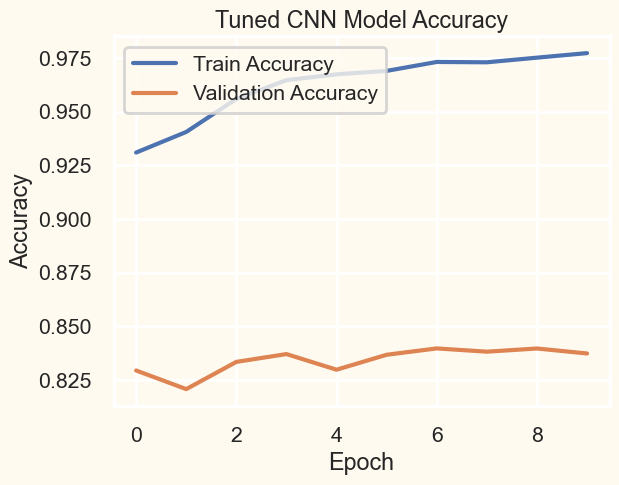

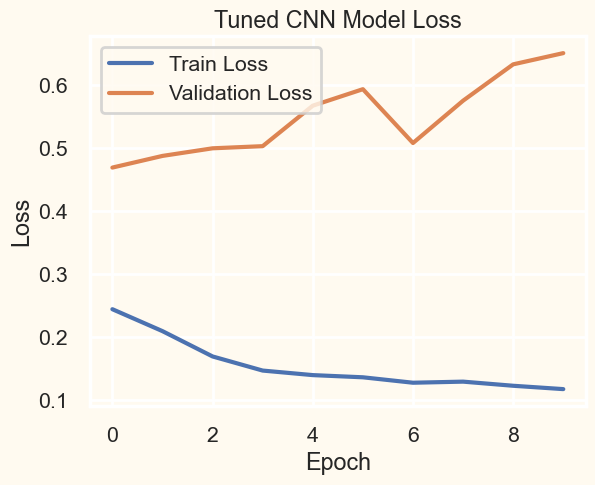

In [416]:
# Plot training and validation accuracy
plt.plot(history_best_CNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_best_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history_best_CNN.history['loss'], label='Train Loss')
plt.plot(history_best_CNN.history['val_loss'], label='Validation Loss')
plt.title('Tuned CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [669]:
best_model_CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │    10,772,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 64)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 96)         │        30,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 32)         │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │        30,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,676,073 (124.65 MB)

 Trainable params: 10,891,725 (41.55 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 21,783,452 (83.10 MB)

In [671]:
# Display the tuning results
tuner.results_summary()



Results summary
Results in hyper_cnn_tuning/Hyper_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_conv_layers: 3
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 96
dropout_rate_0: 0.4
learning_rate: 0.001
dense_units_1: 96
dropout_rate_1: 0.4
filters_1: 96
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 64
dropout_rate_2: 0.2
filters_2: 32
kernel_size_2: 3
pool_size_2: 2
Score: 0.8402400016784668

Trial 03 summary
Hyperparameters:
num_conv_layers: 1
filters_0: 128
kernel_size_0: 7
pool_size_0: 2
num_dense_layers: 1
dense_units_0: 96
dropout_rate_0: 0.1
learning_rate: 0.001
dense_units_1: 32
dropout_rate_1: 0.30000000000000004
filters_1: 64
kernel_size_1: 5
pool_size_1: 2
dense_units_2: 128
dropout_rate_2: 0.1
Score: 0.8399999737739563

Trial 01 summary
Hyperparameters:
num_conv_layers: 2
filters_0: 64
kernel_size_0: 5
pool_size_0: 2
num_dense_layers: 3
dense_units_0: 64
dropout_rate_0: 0.5

# Model Evaluation and Comparision 

### RNN (Recurrent Neural Network)¶


In [418]:
sentiment_labels = {0: 'negative', 1: 'positive'}

In [419]:
RNN_pred = best_model_RNN.predict(X_test)

RNN_pred = (RNN_pred > 0.5).astype('int')

RNN_Accuracy = accuracy_score(RNN_pred,y_test)*100
print("Bidirection_RNN_Accuracy Score is :",RNN_Accuracy,'%')



782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Bidirection_RNN_Accuracy Score is : 82.16 %


In [420]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, RNN_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.789792,0.87648,0.830881,12500.0000
1,0.861251,0.76672,0.811241,12500.0000
accuracy,0.821600,0.82160,0.821600,0.8216
macro avg,0.825522,0.82160,0.821061,25000.0000
weighted avg,0.825522,0.82160,0.821061,25000.0000


### Bidirectional RNN 


In [422]:
BiRNN_pred = best_model_BiRNN.predict(X_test)

BiRNN_pred = (BiRNN_pred > 0.5).astype('int')

Bidirection_RNN_Accuracy = accuracy_score(BiRNN_pred,y_test)*100
print("Bidirection_RNN_Accuracy Score is :",Bidirection_RNN_Accuracy,'%')


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
Bidirection_RNN_Accuracy Score is : 84.32 %


In [423]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, BiRNN_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.867861,0.80968,0.837762,12500.0000
1,0.821637,0.87672,0.848285,12500.0000
accuracy,0.843200,0.84320,0.843200,0.8432
macro avg,0.844749,0.84320,0.843024,25000.0000
weighted avg,0.844749,0.84320,0.843024,25000.0000


### LSTM (Long short Term Memory)¶


In [425]:
LSTM_pred = best_model_LSTM.predict(X_test)


LSTM_pred = (LSTM_pred > 0.5).astype('int')

LSTM_Accuracy = accuracy_score(LSTM_pred,y_test)*100
print("LSTM_Accuracy Score is :",LSTM_Accuracy,'%')

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
LSTM_Accuracy Score is : 84.196 %


In [426]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, LSTM_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.850973,0.82912,0.839904,12500.00000
1,0.833398,0.85480,0.843964,12500.00000
accuracy,0.841960,0.84196,0.841960,0.84196
macro avg,0.842186,0.84196,0.841934,25000.00000
weighted avg,0.842186,0.84196,0.841934,25000.00000


###  GRU (Grated Recurrent Unit)¶


In [428]:
GRU_pred = best_model_GRU.predict(X_test)


GRU_pred = (GRU_pred > 0.5).astype('int')

GRU_Accuracy = accuracy_score(GRU_pred,y_test)*100
print("GRU_Accuracy Score is :",GRU_Accuracy,'%')



782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
GRU_Accuracy Score is : 75.7 %


In [429]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, GRU_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.722735,0.83392,0.774356,12500.000
1,0.803725,0.68008,0.736751,12500.000
accuracy,0.757000,0.75700,0.757000,0.757
macro avg,0.763230,0.75700,0.755554,25000.000
weighted avg,0.763230,0.75700,0.755554,25000.000


### MLP

In [431]:
MLP_pred = best_model_MLP.predict(X_test)

MLP_pred = (MLP_pred > 0.5).astype('int')

MLP_Accuracy = accuracy_score(MLP_pred,y_test)*100
print("Hypertuned_GRU_Accuracy Score is :",MLP_Accuracy,'%')


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
Hypertuned_GRU_Accuracy Score is : 83.052 %


In [432]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, MLP_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df



,precision,recall,f1-score,support
0,0.843633,0.81144,0.827223,12500.00000
1,0.818371,0.84960,0.833693,12500.00000
accuracy,0.830520,0.83052,0.830520,0.83052
macro avg,0.831002,0.83052,0.830458,25000.00000
weighted avg,0.831002,0.83052,0.830458,25000.00000


### CNN

In [434]:
CNN_pred = best_model_CNN.predict(X_test)

CNN_pred = (CNN_pred > 0.5).astype('int')

CNN_Accuracy = accuracy_score(CNN_pred,y_test)*100
print("CNN_Accuracy Score is :",CNN_Accuracy,'%')



782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
CNN_Accuracy Score is : 83.74000000000001 %


In [435]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, CNN_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
0,0.855697,0.81168,0.833108,12500.0000
1,0.820893,0.86312,0.841477,12500.0000
accuracy,0.837400,0.83740,0.837400,0.8374
macro avg,0.838295,0.83740,0.837292,25000.0000
weighted avg,0.838295,0.83740,0.837292,25000.0000


## COMPARAISON

In [438]:
data = {
    'Model': ['RNN','BiRNN', 'LSTM', 'GRU', 'MLP','CNN'],
    'Accuracy': [RNN_Accuracy ,Bidirection_RNN_Accuracy, LSTM_Accuracy, GRU_Accuracy ,MLP_Accuracy,CNN_Accuracy]
}
Acc_df = pd.DataFrame(data)
Acc_df

,Model,Accuracy
0,RNN,82.160
1,BiRNN,84.320
2,LSTM,84.196
3,GRU,75.700
4,MLP,83.052
5,CNN,83.740


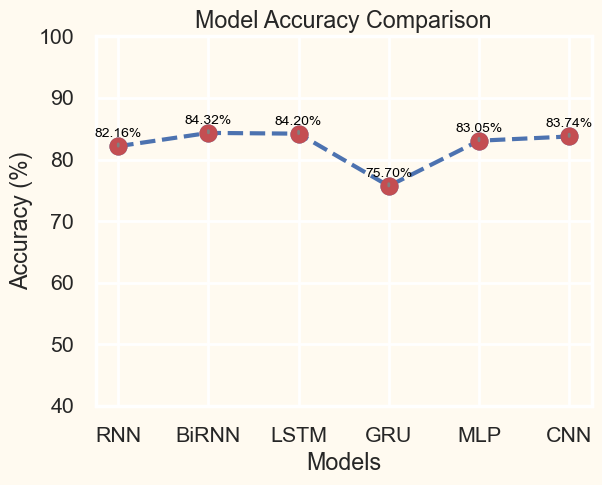

In [439]:
# Plot the DataFrame
ax = Acc_df.plot(x='Model', y='Accuracy', marker='o', linestyle='dashed', color='b', legend=False)

# Add labels, title, and customize the plot
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_ylim(40, 100)  # Set the y-axis limits for percentage values

# Highlight the points and add value labels
for i, accuracy in enumerate(Acc_df['Accuracy']):
    ax.annotate(f'{accuracy:.2f}%', xy=(i, accuracy), xytext=(i, accuracy + 1),
                ha='center', va='bottom', fontsize=10, color='black',
                arrowprops=dict(arrowstyle='-', color='gray'))
    ax.plot(i, accuracy, 'ro')  # Highlight points with red color

# Show the plot
plt.show()



In [440]:
# Define a dictionary of models with their names
models = {
    'RNN': best_model_RNN,
    'BiRNN': best_model_BiRNN,
    'LSTM': best_model_LSTM,
    'GRU': best_model_GRU,
    'MLP': best_model_MLP,
    'CNN': best_model_CNN
}

# Function to calculate memory footprint
def calculate_memory_footprint(model, batch_size=32):
    from tensorflow.keras import backend as K

    # Parameters
    trainable_count = sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = sum([K.count_params(p) for p in model.non_trainable_weights])
    optimizer_count = trainable_count * 2  # Example for Adam optimizer

    # Memory calculation (in MB)
    trainable_memory = trainable_count * 4 / (1024 ** 2)  # Bytes to MB
    non_trainable_memory = non_trainable_count * 4 / (1024 ** 2)  # Bytes to MB
    optimizer_memory = optimizer_count * 4 / (1024 ** 2)  # Bytes to MB

    training_memory = trainable_memory + optimizer_memory
    inference_memory = trainable_memory + non_trainable_memory

    return {
        'train_memory': training_memory,
        'inference_memory': inference_memory
    }

# Loop through models and calculate memory
memory_footprints = {}
for model_name, model in models.items():
    memory_footprints[model_name] = calculate_memory_footprint(model)

# Print results
for model_name, memory in memory_footprints.items():
    print(f"{model_name} Training Memory: {memory['train_memory']:.2f} MB")
    print(f"{model_name} Inference Memory: {memory['inference_memory']:.2f} MB")


RNN Training Memory: 123.60 MB
RNN Inference Memory: 41.20 MB
BiRNN Training Memory: 123.83 MB
BiRNN Inference Memory: 41.28 MB
LSTM Training Memory: 123.49 MB
LSTM Inference Memory: 41.16 MB
GRU Training Memory: 123.44 MB
GRU Inference Memory: 41.15 MB
MLP Training Memory: 126.94 MB
MLP Inference Memory: 42.31 MB
CNN Training Memory: 124.65 MB
CNN Inference Memory: 41.55 MB


RNN Inference Memory: 41.20 MB
BiRNN Inference Memory: 41.28 MB
LSTM Inference Memory: 41.16 MB
GRU Inference Memory: 41.15 MB
MLP Inference Memory: 42.31 MB
CNN Inference Memory: 41.55 MB


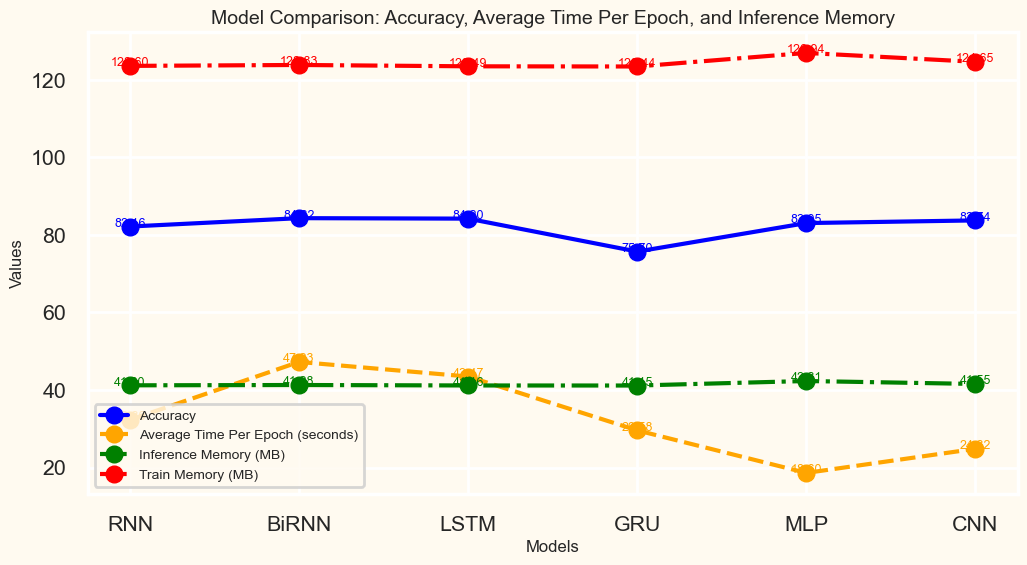

In [693]:
import matplotlib.pyplot as plt

# Example data for models and their respective metrics
models = ["RNN", "BiRNN", "LSTM", "GRU", "MLP", "CNN"]
time_callbacks = {
    "RNN": time_callback_RNN,
    "BiRNN": time_callback_BiRNN,
    "LSTM": time_callback_LSTM,
    "GRU": time_callback_GRU,
    "MLP": time_callback_MLP,
    "CNN": time_callback_CNN
}

# Calculate accuracies for each model
accuracies = [RNN_Accuracy, Bidirection_RNN_Accuracy, LSTM_Accuracy, GRU_Accuracy, MLP_Accuracy, CNN_Accuracy]

# Calculate average times for each model
average_times = [
    sum(time_callbacks[model].epoch_times) / number_epochs
    for model in models
]

# Extract inference memory for each model dynamically
memory_inference = [memory_footprints[model_name]['inference_memory'] for model_name in models]
memory_train = [memory_footprints[model_name]['train_memory'] for model_name in models]

# Print the inference memory for each model
for model_name, memory in zip(models, memory_inference):
    print(f"{model_name} Inference Memory: {memory:.2f} MB")

# Plotting as line chart with actual values
plt.figure(figsize=(12, 6))

plt.plot(models, accuracies, marker='o', label="Accuracy", color='blue', linestyle='-')
plt.plot(models, average_times, marker='o', label="Average Time Per Epoch (seconds)", color='orange', linestyle='--')
plt.plot(models, memory_inference, marker='o', label="Inference Memory (MB)", color='green', linestyle='-.')
plt.plot(models, memory_train, marker='o', label="Train Memory (MB)", color='red', linestyle='-.')

# Annotate points with values
for i, model in enumerate(models):
    plt.text(i, accuracies[i], f"{accuracies[i]:.2f}", color='blue', ha='center', fontsize=9)
    plt.text(i, average_times[i], f"{average_times[i]:.2f}", color='orange', ha='center', fontsize=9)
    plt.text(i, memory_inference[i], f"{memory_inference[i]:.2f}", color='green', ha='center', fontsize=9)
    plt.text(i, memory_train[i], f"{memory_train[i]:.2f}", color='red', ha='center', fontsize=9)

# Add labels, title, and legend
plt.title("Model Comparison: Accuracy, Average Time Per Epoch, and Inference Memory", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


## The majority vote

In [442]:
import numpy as np
from sklearn.metrics import accuracy_score


# Stack predictions
all_preds = np.stack([RNN_pred, BiRNN_pred, LSTM_pred, GRU_pred, CNN_pred, MLP_pred], axis=1)

# Perform majority voting
ensemble_preds = (np.sum(all_preds, axis=1) > (len(all_preds[0]) // 2)).astype(int)

# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Compare with individual models
individual_accuracies = {
    "RNN": accuracy_score(y_test, RNN_pred),
    "BiRNN": accuracy_score(y_test, BiRNN_pred),
    "LSTM": accuracy_score(y_test, LSTM_pred),
    "GRU": accuracy_score(y_test, GRU_pred),
    "CNN": accuracy_score(y_test, CNN_pred),
    "MLP": accuracy_score(y_test, MLP_pred)
}

print("\nIndividual Model Accuracies:")
for model, acc in individual_accuracies.items():
    print(f"{model}: {acc:.4f}")

print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")


Ensemble Accuracy: 0.8588

Individual Model Accuracies:
RNN: 0.8216
BiRNN: 0.8432
LSTM: 0.8420
GRU: 0.7570
CNN: 0.8374
MLP: 0.8305

Ensemble Accuracy: 0.8588


In [505]:
enhanced_models = [
    model for model, acc in individual_accuracies.items() 
    if ensemble_accuracy > acc
]
print("Models enhanced by ensembling:", enhanced_models)


Models enhanced by ensembling: ['RNN', 'BiRNN', 'LSTM', 'GRU', 'CNN', 'MLP']


Based on the results obtained, we see that the results from the synthesis of all 5 methods above are better than the results of each method. So we can say that all 5 methods above are improved.

## BONUS: unlabeled data

In [274]:
import os
import pandas as pd

# Đường dẫn tới thư mục chứa các file .txt
folder_path = "unsup"

# Tạo một danh sách để lưu trữ dữ liệu từ các file
data_list = []

# Lặp qua tất cả các file trong thư mục
for file_name in os.listdir(folder_path):
    # Kiểm tra nếu file có đuôi .txt
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        
        # Đọc nội dung của file .txt
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        
        # Lưu trữ nội dung và tên file vào danh sách
        data_list.append({"text": content})

# Chuyển danh sách thành DataFrame
unlabeled = pd.DataFrame(data_list)

# Hiển thị DataFrame
print(unlabeled.head())

# Lưu DataFrame vào file CSV nếu cần
unlabeled.to_csv("unsup_data.csv", index=False)


                                                text
0  A newspaperman (Johnny Twennies) living in the...
1  As co-founder of Nicko & Joe's Bad Film Club S...
2  Very good film from director Wyler, although i...
3  This flick will pass the time, and Kurt Russle...
4  The Feeding is a terrible werewolf movie about...


In [444]:
unlabeled = pd.read_csv('unsup_data.csv')

In [445]:

# Apply preprocessing to unlabeled data
#unlabeled['text'] = unlabeled['text'].apply(preprocess_text).apply(lemmatize_text)

# Tokenization
#def do_tokenization(text):
#    return word_tokenize(text)

#unlabeled['text'] = unlabeled['text'].apply(do_tokenization)
# Pad sequences to a fixed length (maxlen = 100)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(unlabeled['text'])
sequences = tokenizer.texts_to_sequences(unlabeled['text'])
unlabeled_sequences = pad_sequences(sequences, maxlen=100, padding="post")


In [446]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 5000  # Vocabulary size
max_sequence_length = 100  # Sequence length for padding
embedding_dim = 100  # Embedding dimensions
epochs_pretrain = 10  # Pretraining epochs
epochs_finetune = 10  # Fine-tuning epochs
batch_size = 32  # Batch size

# Step 1: Filter sequences to ensure indices are within vocab_size
def filter_sequences(sequences, vocab_size):
    return np.clip(sequences, 0, vocab_size - 1)  # Clip indices to valid range

unlabeled_sequences = filter_sequences(unlabeled_data, vocab_size)
X_train = filter_sequences(X_train, vocab_size)
X_test = filter_sequences(X_test, vocab_size)

# Step 2: Pretraining Model
def create_pretraining_rnn(vocab_size, embedding_dim, max_sequence_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, name="pretrain_embedding"),
        SimpleRNN(64, return_sequences=True, name="pretrain_rnn"),
        Dense(vocab_size, activation='softmax', name="pretrain_output")  # Predict next word or reconstruct sequence
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Fine-tuning Model
def create_finetuning_rnn(vocab_size, embedding_dim, max_sequence_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, name="finetune_embedding"),
        SimpleRNN(64, name="finetune_rnn"),
        Dropout(0.5, name="finetune_dropout"),
        Dense(1, activation='sigmoid', name="finetune_output")  # Binary classification (sentiment analysis)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




In [447]:
# Step 4: Pretraining
print("Pretraining RNN on unlabeled data...")
pretrain_rnn = create_pretraining_rnn(vocab_size, embedding_dim, max_sequence_length)
pretrain_rnn.fit(unlabeled_sequences, unlabeled_sequences, epochs=epochs_pretrain, batch_size=batch_size)



Pretraining RNN on unlabeled data...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - accuracy: 0.4086 - loss: 4.0829
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.9991 - loss: 0.0670
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - accuracy: 1.0000 - loss: 4.5142e-04
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 1.0000 - loss: 2.1163e-04
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 1.0000 - loss: 1.0103e-04
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 1.0000 - loss: 4.9948e-05
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 1.0000 - loss: 2.6187e-05


In [448]:
# Step 5: Fine-tuning
print("Fine-tuning RNN on labeled data...")
finetune_rnn = create_finetuning_rnn(vocab_size, embedding_dim, max_sequence_length)

# Ensure models are built to initialize weights
dummy_input = np.zeros((1, max_sequence_length))
pretrain_rnn(dummy_input)
finetune_rnn(dummy_input)

# Transfer weights from pretraining model to fine-tuning model
finetune_rnn.get_layer("finetune_embedding").set_weights(pretrain_rnn.get_layer("pretrain_embedding").get_weights())
finetune_rnn.get_layer("finetune_rnn").set_weights(pretrain_rnn.get_layer("pretrain_rnn").get_weights())



Fine-tuning RNN on labeled data...


In [449]:
# Step 6: Train the fine-tuned model

# Attach the callback
time_callback_fintune = TimeHistory()

history = finetune_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_finetune, batch_size=batch_size,callbacks=[time_callback_fintune])

# Get epoch times
print(f"Fine tuned RNN Time Per Epoch: {time_callback_fintune.epoch_times}")
print(f"Fine tuned RNN Total Training Time: {sum(time_callback_fintune.epoch_times):.2f} seconds")
print(f"Fine tuned RNN Average Time Per Epoch: {(sum(time_callback_fintune.epoch_times))/number_epochs:.2f} seconds")

# Step 7: Evaluate the model
print("\nFine-tuned RNN Results:")
final_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {final_accuracy:.4f}")





Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4973 - loss: 0.8940 - val_accuracy: 0.5183 - val_loss: 0.6899
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5199 - loss: 0.7008 - val_accuracy: 0.5268 - val_loss: 0.6895
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5344 - loss: 0.6890 - val_accuracy: 0.5260 - val_loss: 0.6858
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5391 - loss: 0.6857 - val_accuracy: 0.5338 - val_loss: 0.6828
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5588 - loss: 0.6747 - val_accuracy: 0.5390 - val_loss: 0.6764
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5826 - loss: 0.6600 - val_accuracy: 0.5523 - val_loss: 0.6695
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5955 - loss: 0.6400 - val_accuracy: 0.5582 - val_loss: 0.6637
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6278 - loss: 0.6100 - val_accu

In [513]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Parameters
vocab_size = 5000  # Vocabulary size
max_sequence_length = 100  # Sequence length for padding
embedding_dim = 100  # Embedding dimensions
epochs_pretrain = 10  # Pretraining epochs
epochs_finetune = 10  # Fine-tuning epochs
batch_size = 32  # Batch size
learning_rate = 0.0001  # From tuned hyperparameters

def filter_sequences(sequences, vocab_size):
    return np.clip(sequences, 0, vocab_size - 1)  # Clip indices to valid range

unlabeled_sequences = filter_sequences(unlabeled_sequences, vocab_size)
X_train = filter_sequences(X_train, vocab_size)
X_test = filter_sequences(X_test, vocab_size)

# Step 1: Prepare targets for pretraining
def prepare_pretraining_targets(sequences):
    """
    Prepares input and target sequences for pretraining.
    The input sequence predicts the next word in the sequence.
    """
    input_sequences = sequences[:, :-1]  # All except the last word
    target_sequences = sequences[:, 1:]  # All except the first word
    return input_sequences, target_sequences

pretrain_inputs, pretrain_targets = prepare_pretraining_targets(unlabeled_sequences)

# Step 2: Pretraining Model
def create_pretraining_rnn(vocab_size, embedding_dim, max_sequence_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, name="pretrain_embedding")
    ])
    for i in range(num_rnn_layers):
        model.add(SimpleRNN(rnn_units[i], return_sequences=True, activation='tanh', name=f"pretrain_rnn_{i}"))
        model.add(Dropout(dropout_rates[i], name=f"pretrain_dropout_{i}"))
        model.add(BatchNormalization(name=f"pretrain_batchnorm_{i}"))
    model.add(Dense(vocab_size, activation='softmax', name="pretrain_output"))  # Keep Dense layer for time steps
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def create_updated_finetuning_rnn(vocab_size, embedding_dim, max_sequence_length):
    model = Sequential([
        # Embedding Layer
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, name="finetune_embedding"),
        
        # First SimpleRNN Layer
        SimpleRNN(64, return_sequences=True, activation='tanh', name="finetune_rnn_0"),
        Dropout(0.5, name="finetune_dropout_0"),
        BatchNormalization(name="finetune_batchnorm_0"),
        
        # Second SimpleRNN Layer
        SimpleRNN(64, return_sequences=False, activation='tanh', name="finetune_rnn_1"),
        Dropout(0.5, name="finetune_dropout_1"),
        BatchNormalization(name="finetune_batchnorm_1"),
        
        # Dense Layer with 128 units
        Dense(128, activation='relu', name="finetune_dense_0"),
        Dropout(0.5, name="finetune_dropout_dense_0"),
        BatchNormalization(name="finetune_batchnorm_dense_0"),
        
        # Final Output Layer
        Dense(1, activation='sigmoid', name="finetune_output")
    ])
    
    # Compile the Model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model



In [515]:
# Step 1: Pretraining
print("Pretraining RNN on unlabeled data...")
pretrain_rnn = create_pretraining_rnn(vocab_size, embedding_dim, max_sequence_length - 1)  # Reduce input length by 1
pretrain_rnn.fit(pretrain_inputs, pretrain_targets, epochs=epochs_pretrain, batch_size=batch_size)

# Step 2: Fine-tuning
print("Fine-tuning RNN on labeled data...")
finetune_rnn = create_finetuning_rnn(vocab_size, embedding_dim, max_sequence_length)

# Ensure models are built to initialize weights
dummy_input = np.zeros((1, max_sequence_length))
pretrain_rnn(dummy_input[:, :-1])  # Match pretraining input shape
finetune_rnn(dummy_input)

# Transfer weights from pretraining model to fine-tuning model
finetune_rnn.get_layer("finetune_embedding").set_weights(pretrain_rnn.get_layer("pretrain_embedding").get_weights())
for i in range(num_rnn_layers):
    finetune_rnn.get_layer(f"finetune_rnn_{i}").set_weights(pretrain_rnn.get_layer(f"pretrain_rnn_{i}").get_weights())

# Step 3: Train the fine-tuned model

# Attach the callback
time_callback_fintune = TimeHistory()

history = finetune_rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs_finetune, batch_size=batch_size,callbacks=[time_callback_fintune])

# Get epoch times
print(f"Fine tuned RNN Time Per Epoch: {time_callback_fintune.epoch_times}")
print(f"Fine tuned RNN Total Training Time: {sum(time_callback_fintune.epoch_times):.2f} seconds")
print(f"Fine tuned RNN Average Time Per Epoch: {(sum(time_callback_fintune.epoch_times))/number_epochs:.2f} seconds")

# Step 4: Evaluate the model
print("\nFine-tuned RNN Results:")
final_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {final_accuracy:.4f}")

Pretraining RNN on unlabeled data...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 70ms/step - accuracy: 0.0585 - loss: 8.1277
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - accuracy: 0.1040 - loss: 6.4150
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - accuracy: 0.1159 - loss: 5.9868
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 112s 72ms/step - accuracy: 0.1379 - loss: 5.7096
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.1535 - loss: 5.5619
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - accuracy: 0.1621 - loss: 5.4601
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - accuracy: 0.1654 - loss: 5.4029
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - accuracy: 0.1666 - loss: 5.3597
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - accuracy: 0.1685 - loss: 5.3245
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.1707 - loss: 5.2827
Fine-tuning RNN on labeled data...
Epoch 1/10
782/78

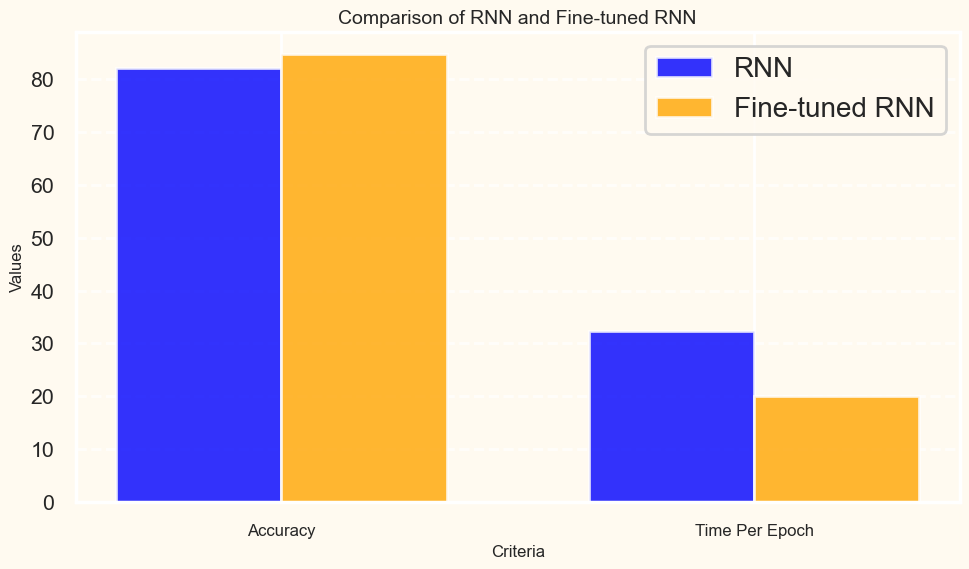

In [535]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual values)
models = ["RNN", "Fine-tuned RNN"]
criteria = ["Accuracy", "Time Per Epoch"]

# Data for each criterion
accuracies = [RNN_Accuracy, final_accuracy*100]  # Replace with actual values
epoch_times = [
    sum(time_callback_RNN.epoch_times) / number_epochs,  # Replace with actual RNN epoch time
    sum(time_callback_fintune.epoch_times) / number_epochs,  # Replace with fine-tuned epoch time
]

# Combine data
data = [accuracies, epoch_times]
data = np.array(data)  # Convert to numpy array for easier manipulation

# Bar settings
bar_width = 0.35
x = np.arange(len(criteria))  # Number of criteria

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each model
ax.bar(x - bar_width / 2, data[:, 0], bar_width, label="RNN", color="blue", alpha=0.8)
ax.bar(x + bar_width / 2, data[:, 1], bar_width, label="Fine-tuned RNN", color="orange", alpha=0.8)

# Add labels, title, and legend
ax.set_xlabel("Criteria", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Comparison of RNN and Fine-tuned RNN", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(criteria, fontsize=12)
ax.legend(fontsize=20)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Above are the results obtained from 2 RNNs models, both trained with the same hyperparametries and the same architecture: 1 model is trained on the IMDA dataset, 1 model is pretrained on unlabeled data and then fine tuned. We see that pretraining the model has helped improve the accuracy of the model.